In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
plt.rcParams['figure.figsize']=(10, 6)

In [3]:
# file downloaded from http://www.healthdata.org/covid/data-downloads on 2020-10-06
df = pd.read_csv('Reference_hospitalization_all_locs.csv')

In [4]:
locations = ['Germany', 'Baden-Württemberg',
       'Bavaria', 'Berlin', 'Brandenburg', 'Bremen', 'Hamburg', 'Hesse',
       'Lower Saxony', 'Mecklenburg-Vorpommern', 'North Rhine-Westphalia',
       'Rhineland-Palatinate', 'Saarland', 'Saxony-Anhalt', 'Saxony',
       'Schleswig-Holstein', 'Thuringia']

In [5]:
df = df[['date', 'location_name', 'confirmed_infections', 'totdea_mean']][df.location_name.isin(locations)].dropna()

In [6]:
df.confirmed_infections = df.confirmed_infections.astype(int)
df.totdea_mean = df.totdea_mean.astype(int)
df.date = pd.to_datetime(df.date)

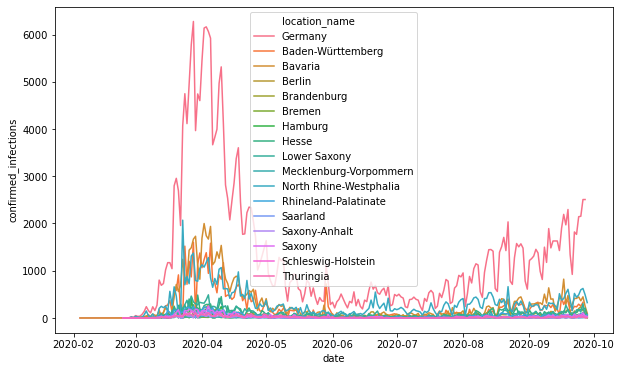

In [7]:
sb.lineplot(data=df, x='date', y='confirmed_infections', hue='location_name')

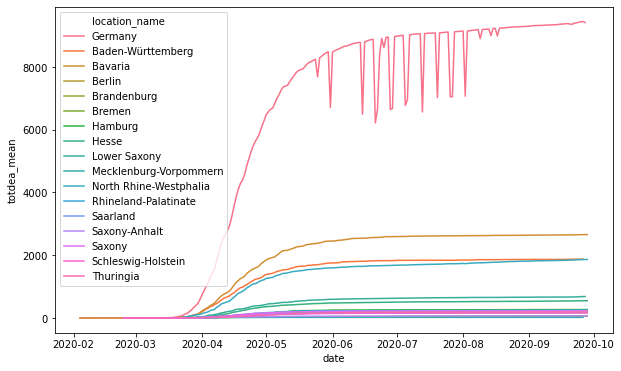

In [8]:
sb.lineplot(data=df, x='date', y='totdea_mean', hue='location_name')

In [9]:
fips_english = pd.read_csv('../../template/base_germany.csv')

In [10]:
loc_dict = {'Baden-Württemberg': 'Baden-Württemberg State', 'Bavaria': 'Free State of Bavaria', 
            'Berlin': 'Berlin State', 'Brandenburg': 'Brandenburg State', 'Bremen' : 'Free Hanseatic City of Bremen', 
            'Hamburg': 'Free Hanseatic City of Hamburg', 'Hesse': 'Hesse State', 'Lower Saxony': 'Lower Saxony State',
            'Mecklenburg-Vorpommern': 'Mecklenburg-Western Pomerania State', 
            'North Rhine-Westphalia' : 'North Rhine-Westphalia State',
            'Rhineland-Palatinate': 'Rhineland-Palatinate State', 'Saarland': 'Saarland State', 
            'Saxony-Anhalt': 'Sachsen-Anhalt State', 'Saxony': 'Free State of Saxony',
            'Schleswig-Holstein': 'Schleswig-Holstein State', 'Thuringia': 'Free State of Thüringia'}

In [11]:
df.location_name.replace(loc_dict, inplace=True)

In [12]:
df = df.merge(fips_english, left_on='location_name', right_on='V2', how='left').drop(columns='V2')

In [13]:
df.rename(columns={'V1': 'location'}, inplace=True)

In [14]:
df.location.fillna('GM', inplace=True)

In [15]:
df = df[df.date <= '2020-03-31'].sort_values(['date', 'location']).reset_index(drop=True)

In [16]:
df

,date,location_name,confirmed_infections,totdea_mean,location
0,2020-02-04,Germany,0,0,GM
1,2020-02-04,Free State of Bavaria,0,0,GM02
2,2020-02-05,Germany,0,0,GM
3,2020-02-05,Free State of Bavaria,0,0,GM02
4,2020-02-06,Germany,0,0,GM
...,...,...,...,...,...
658,2020-03-31,Mecklenburg-Western Pomerania State,10,1,GM12
659,2020-03-31,Free State of Saxony,86,12,GM13
660,2020-03-31,Sachsen-Anhalt State,88,6,GM14
661,2020-03-31,Free State of Thüringia,65,6,GM15


# Deaths

### Cumulative

In [17]:
df_deaths_cum = df.drop(columns='confirmed_infections').rename(columns={'totdea_mean': 'value'})
df_deaths_cum = df_deaths_cum[['date', 'location', 'location_name', 'value']]

In [18]:
df_deaths_cum

,date,location,location_name,value
0,2020-02-04,GM,Germany,0
1,2020-02-04,GM02,Free State of Bavaria,0
2,2020-02-05,GM,Germany,0
3,2020-02-05,GM02,Free State of Bavaria,0
4,2020-02-06,GM,Germany,0
...,...,...,...,...
658,2020-03-31,GM12,Mecklenburg-Western Pomerania State,1
659,2020-03-31,GM13,Free State of Saxony,12
660,2020-03-31,GM14,Sachsen-Anhalt State,6
661,2020-03-31,GM15,Free State of Thüringia,6


In [19]:
rki_deaths_cum = pd.read_csv('../../data-truth/RKI/truth_RKI-Cumulative Deaths_Germany.csv', parse_dates=['date'])

In [20]:
all_deaths_cum = pd.concat([df_deaths_cum, rki_deaths_cum])

In [21]:
all_deaths_cum.drop_duplicates(subset=['date', 'location'], keep='first', inplace=True)

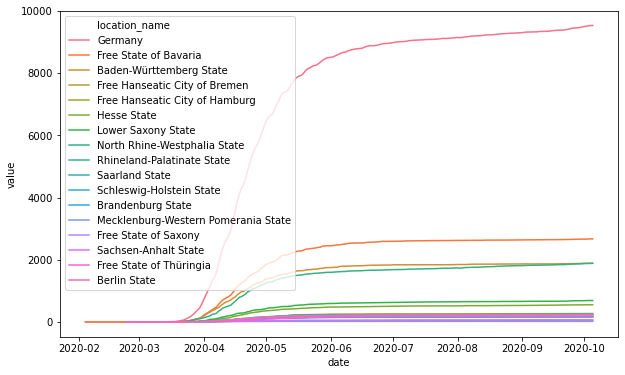

In [22]:
sb.lineplot(data=all_deaths_cum, x='date', y='value', hue='location_name')

In [23]:
all_deaths_cum.to_csv('../../data-truth/RKI/truth_RKI-Cumulative Deaths_Germany.csv', index=False)

### Incidence

In [24]:
df_deaths_inc = df_deaths_cum.copy()
df_deaths_inc.value = df_deaths_inc.groupby('location').value.diff()
df_deaths_inc.dropna(subset=['value'], inplace=True)
df_deaths_inc.value = df_deaths_inc.value.astype(int)

In [25]:
df_deaths_inc

,date,location,location_name,value
2,2020-02-05,GM,Germany,0
3,2020-02-05,GM02,Free State of Bavaria,0
4,2020-02-06,GM,Germany,0
5,2020-02-06,GM02,Free State of Bavaria,0
6,2020-02-07,GM,Germany,0
...,...,...,...,...
658,2020-03-31,GM12,Mecklenburg-Western Pomerania State,0
659,2020-03-31,GM13,Free State of Saxony,3
660,2020-03-31,GM14,Sachsen-Anhalt State,4
661,2020-03-31,GM15,Free State of Thüringia,1


In [26]:
rki_deaths_inc = pd.read_csv('../../data-truth/RKI/truth_RKI-Incident deaths_Germany.csv', parse_dates=['date'])

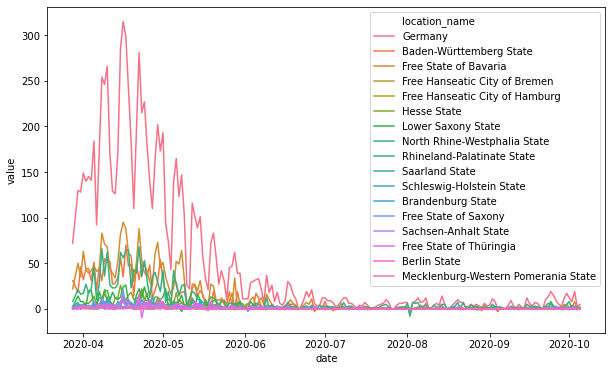

In [27]:
sb.lineplot(data=rki_deaths_inc, x='date', y='value', hue='location_name')

In [28]:
rki_deaths_inc.head()

,date,location,location_name,value
0,2020-03-28,GM,Germany,72
1,2020-03-28,GM01,Baden-Württemberg State,31
2,2020-03-28,GM02,Free State of Bavaria,22
3,2020-03-28,GM03,Free Hanseatic City of Bremen,1
4,2020-03-28,GM04,Free Hanseatic City of Hamburg,0


In [29]:
all_deaths_inc = pd.concat([df_deaths_inc, rki_deaths_inc])

In [30]:
all_deaths_inc.drop_duplicates(subset=['date', 'location'], keep='first', inplace=True)

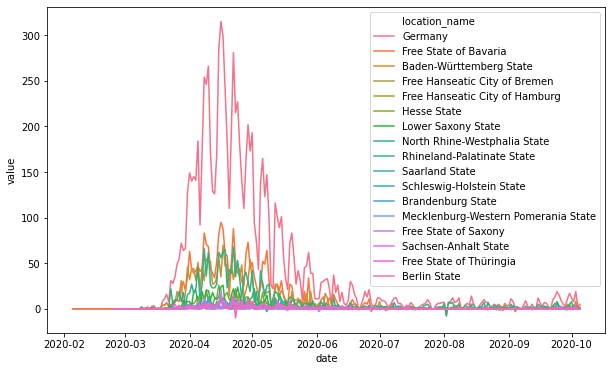

In [31]:
sb.lineplot(data=all_deaths_inc, x='date', y='value', hue='location_name')

In [33]:
all_deaths_inc.to_csv('../../data-truth/RKI/truth_RKI-Incident deaths_Germany.csv', index=False)

# Cases

### Incidence

In [34]:
df_cases_inc = df.drop(columns='totdea_mean').rename(columns={'confirmed_infections': 'value'})
df_cases_inc = df_cases_inc[['date', 'location', 'location_name', 'value']]

In [35]:
df_cases_inc

,date,location,location_name,value
0,2020-02-04,GM,Germany,0
1,2020-02-04,GM02,Free State of Bavaria,0
2,2020-02-05,GM,Germany,0
3,2020-02-05,GM02,Free State of Bavaria,0
4,2020-02-06,GM,Germany,0
...,...,...,...,...
658,2020-03-31,GM12,Mecklenburg-Western Pomerania State,10
659,2020-03-31,GM13,Free State of Saxony,86
660,2020-03-31,GM14,Sachsen-Anhalt State,88
661,2020-03-31,GM15,Free State of Thüringia,65


In [36]:
rki_cases_inc = pd.read_csv('../../data-truth/RKI/truth_RKI-Incident Cases_Germany.csv', parse_dates=['date'])

In [37]:
rki_cases_inc.head()

,date,location,location_name,value
0,2020-03-28,GM,Germany,6294
1,2020-03-28,GM01,Baden-Württemberg State,1620
2,2020-03-28,GM02,Free State of Bavaria,1669
3,2020-03-28,GM03,Free Hanseatic City of Bremen,19
4,2020-03-28,GM04,Free Hanseatic City of Hamburg,72


In [38]:
all_cases_inc = pd.concat([df_cases_inc, rki_cases_inc])

In [39]:
all_cases_inc.drop_duplicates(subset=['date', 'location'], keep='first', inplace=True)

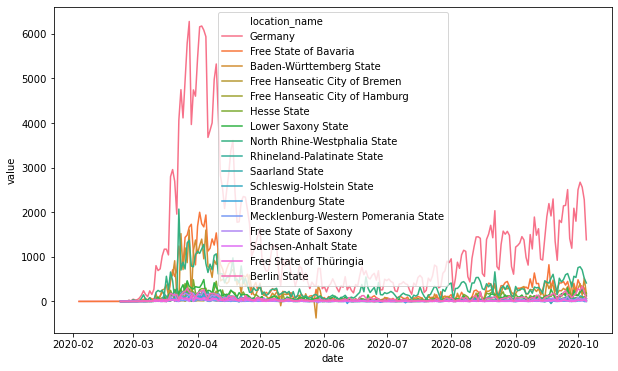

In [40]:
sb.lineplot(data=all_cases_inc, x='date', y='value', hue='location_name')

In [41]:
all_cases_inc.to_csv('../../data-truth/RKI/truth_RKI-Incident Cases_Germany.csv', index=False)

### Cumulative

In [42]:
rki_cases_cum = pd.read_csv('../../data-truth/RKI/truth_RKI-Cumulative Cases_Germany.csv', parse_dates=['date'])

In [43]:
df_cases_cum = df_cases_inc.copy()

In [44]:
df_cases_cum.value = df_cases_cum.groupby('location')['value'].cumsum()

In [45]:
all_cases_cum = pd.concat([df_cases_cum, rki_cases_cum])

In [46]:
all_cases_cum.drop_duplicates(subset=['date', 'location'], keep='first', inplace=True)

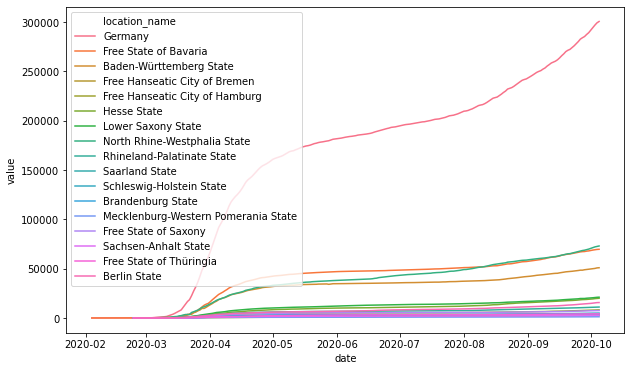

In [47]:
sb.lineplot(data=all_cases_cum, x='date', y='value', hue='location_name')

In [48]:
all_cases_cum.to_csv('../../data-truth/RKI/truth_RKI-Cumulative Cases_Germany.csv', index=False)